In [22]:
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append(os.path.abspath(".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
from movie_recommender.workflow import read_parquet_from_s3, connect_minio
from training.xgb import (split_genres, get_genre_stats, get_user_data,get_movies_data,get_possible_genres)
import gc

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000"
connect_minio()
gc.enable()

Available Buckets [Bucket('mlflowbucket'), Bucket('trainingbucket')]


In [24]:
ratings = read_parquet_from_s3("trainingbucket", "ratings.parquet")
movies = read_parquet_from_s3("trainingbucket", "movies.parquet")
ratings = ratings.merge(movies, on="movie_id")
ratings.rating *= 5 

In [25]:
def IQR(series:pd.Series,a=1.5):
    q1 = series.quantile(0.25)
    q2 = series.quantile(0.75)
    iqr = (q2-q1) * a
    return series[series.between(q1 - iqr, q2 + iqr)]

In [26]:
eda_df = ratings.copy()

<Axes: ylabel='movie_year'>

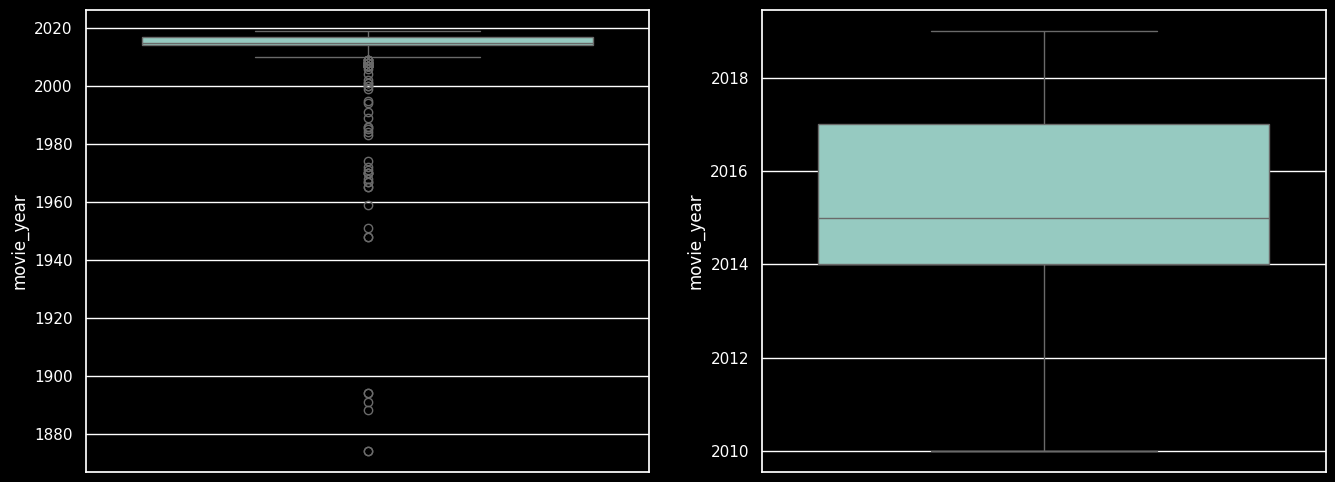

In [27]:
_, axes = plt.subplots(1, 2,figsize=(16,6))
sns.boxplot(y=eda_df.movie_year, ax=axes[0])
sns.boxplot(y=IQR(eda_df.movie_year), ax=axes[1])

In [28]:
eda_df = split_genres(eda_df)

In [29]:
genres_counts, genres_avg_ratings = get_genre_stats(eda_df)

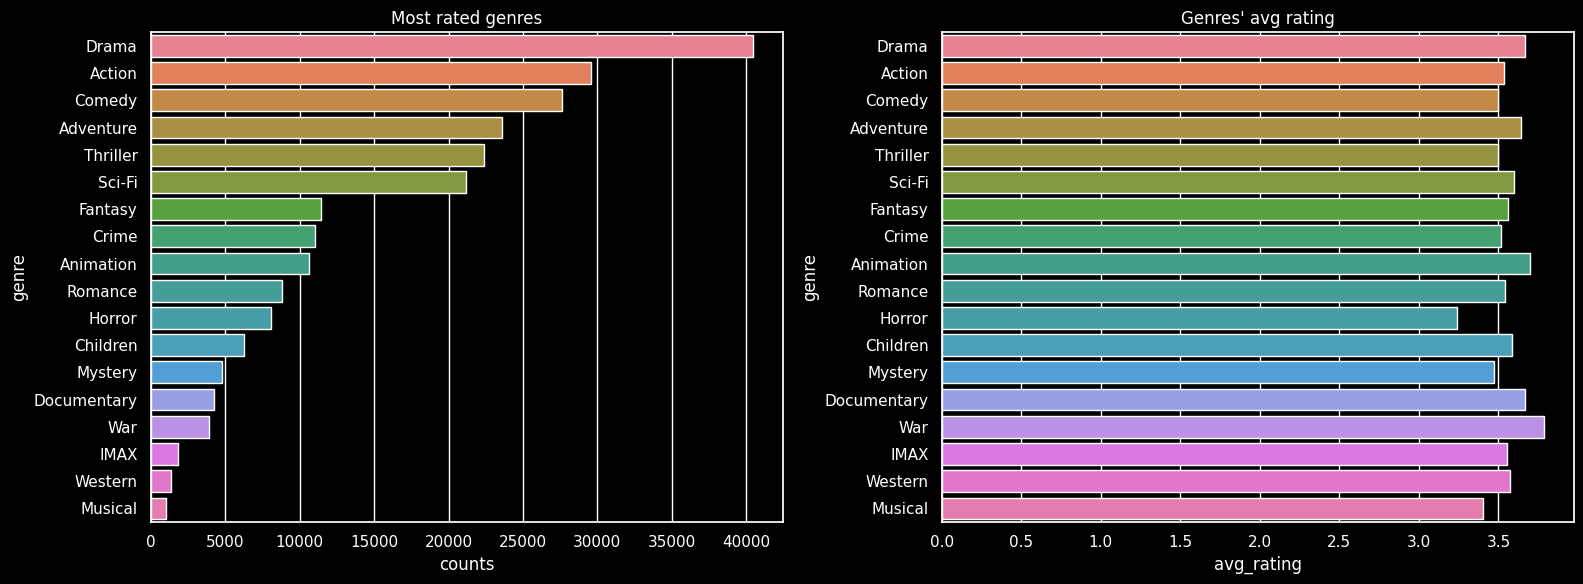

In [30]:
genres_data = pd.merge(
    pd.DataFrame(dict(genres_counts), index=[
                 "counts"]).T.reset_index(names="genre"),
    pd.DataFrame(dict(genres_avg_ratings), index=[
                 "avg_rating"]).T.reset_index(names="genre"),
    on="genre"
).sort_values("counts",ascending=False)

_,axes = plt.subplots(1,2,figsize=(16,6))
sns.barplot(genres_data, x="counts", y="genre", hue='genre',ax=axes[0]).set_title("Most rated genres")
plt.title("Most rated genres")


sns.barplot(genres_data, x="avg_rating", y="genre", hue='genre',ax=axes[1]).set_title("Genres' avg rating")
plt.tight_layout()

In [31]:
genres = get_possible_genres(eda_df)
ratings_with_genres = eda_df.copy()
ratings_with_genres[genres] = eda_df.movie_genres.apply(lambda movie_genres: [item in movie_genres for item in genres]).tolist()

<Axes: xlabel='Avg rating', ylabel='Genre'>

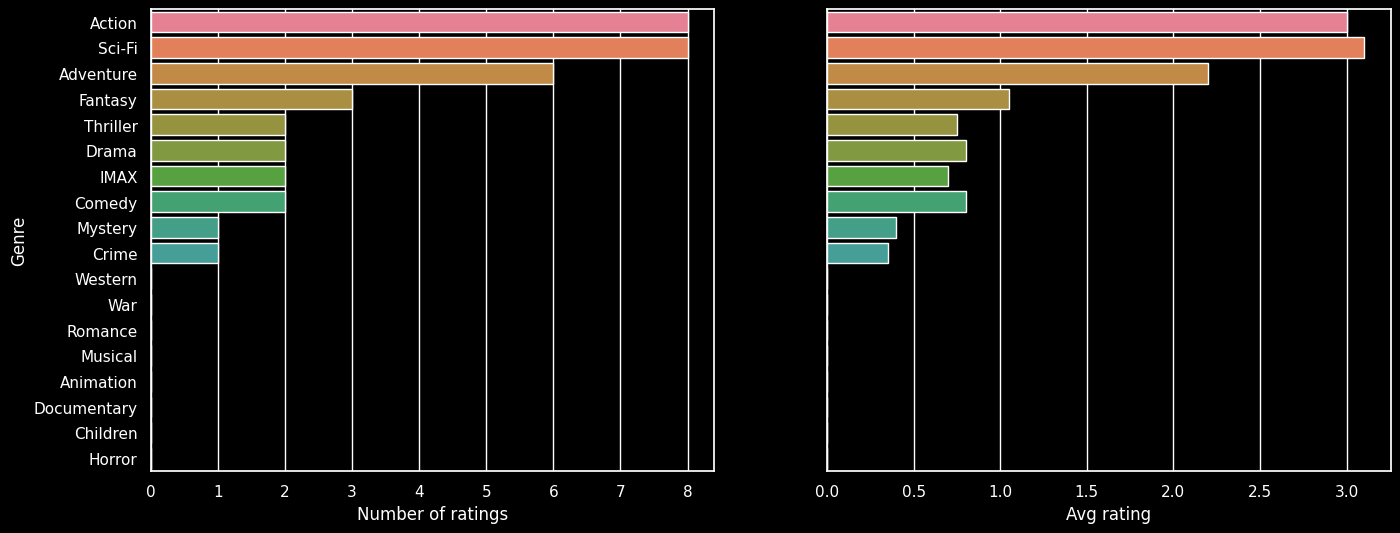

In [32]:
user_genres_counts, user_genres_mean, user_data = get_user_data(eda_df)

user_id = 0
user_df = pd.merge(
    user_genres_counts.loc[user_id].to_frame().reset_index(
        names="Genre").rename(columns={user_id: "Number of ratings"}),
    user_genres_mean.loc[user_id].to_frame().reset_index(
        names="Genre").rename(columns={user_id: "Avg rating"}),
    on="Genre"
).sort_values("Number of ratings", ascending=False)

_, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.barplot(user_df, y="Genre", x="Number of ratings", hue="Genre", ax=axes[0])
sns.barplot(user_df, y="Genre", x="Avg rating", hue="Genre", ax=axes[1])

In [33]:
import xgboost as xgb

def train_xgb(
    params,
    X_train, y_train, X_test, y_test,
    **kwargs,
):
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_test, y_test)
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "train"), (dval, "val")],
        **kwargs,
    )
    return booster

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from movie_recommender.train_utils import fix_split

In [36]:
from training.xgb import main,read_parquet_from_s3
booster = main(ratings)

[I 2025-09-20 08:49:44,844] A new study created in memory with name: no-name-583b0874-6fc5-4691-a72d-e95b2e28f46b


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-20 08:49:52,323] Trial 0 finished with value: 0.14025552786907 and parameters: {'objective': 'reg:squarederror', 'device': 'cuda', 'random_state': 0, 'eval_metric': 'mae', 'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.10046308588879356, 'subsample': 0.6607188919476781, 'colsample_bytree': 0.7263688906996146, 'gamma': 2.770686325097949, 'lambda': 3.801928223723201, 'alpha': 2.571974779513172}. Best is trial 0 with value: 0.14025552786907.
[I 2025-09-20 08:50:01,026] Trial 1 finished with value: 0.13992179174820174 and parameters: {'objective': 'reg:squarederror', 'device': 'cuda', 'random_state': 0, 'eval_metric': 'mae', 'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.014618856785208342, 'subsample': 0.7077748716873101, 'colsample_bytree': 0.9439793068357547, 'gamma': 2.8352300095796954, 'lambda': 3.2055316800712186, 'alpha': 2.8239361300128034}. Best is trial 1 with value: 0.13992179174820174.
[I 2025-09-20 08:50:08,362] Trial 2 finished with value: 0.1398